# **1. Importación de *modules***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# **2. Importación del dataset *properatti_tp2.csv***

In [2]:
data = pd.read_csv("../data/properatti_tp2.csv", sep = ",", low_memory=False) 
data.head(3)
data.shape

,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,am_garage,am_balcon,am_parrilla,am_piscina,am_terraza,am_patio,...,pn_Villa de Mayo,pn_Villa del Parque,pn_Village Golf & Tennis Country Club,pn_Virasoro Village,pn_Virrey del Pino,pn_Virreyes,pn_Wilde,pn_William Morris,pn_Zelaya,pn_coordenadas 34.255511
0,55.0,40.0,1127.272727,2.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,55.0,55.0,1309.090909,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,106.0,78.0,1226.415094,2.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


(41760, 467)

# **3. Tratamiento de los datos**

<AxesSubplot:>

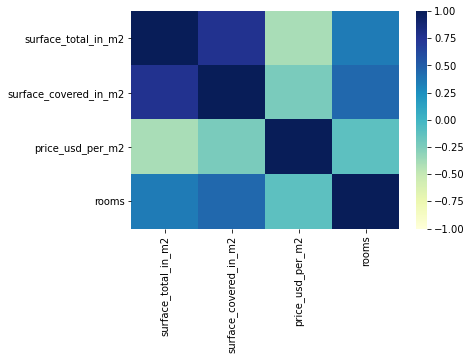

In [3]:
sns.heatmap(data.iloc[:, :4].corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu")

# **4.Modelos**

## Creo una función que ingreso features y devuelve el MAE

In [46]:
# Definimos una función que acepta una lista de features, hace el split entre train y test,
# reservando un 25% de las observaciones para testeo, y devuelve la prueba MAE.

def train_test_mae(feature_cols):
    X = data[feature_cols]
    y = data.price_usd_per_m2
    # Como estamos trabajando con observaciones ordenadas en el tiempo, ponemos
    # shuffle=False para evitar data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return metrics.mean_absolute_error(y_test, y_pred)

In [48]:
train_test_mae(['surface_total_in_m2','surface_covered_in_m2','rooms'])

705.1883861779858

## **Regresión lineal simple (RLS)**

### Regresión lineal simple (RLS) de a una feature a la vez **sin normalización**

In [4]:
X1 = data[['surface_total_in_m2']]
X2 = data[['surface_covered_in_m2']]
X3 = data[['rooms']]
y = data['price_usd_per_m2']

In [5]:
X1train, X1test, y1train, y1test = train_test_split(X1, y, random_state = 1)
X2train, X2test, y2train, y2test = train_test_split(X2, y, random_state = 1)
X3train, X3test, y3train, y3test = train_test_split(X3, y, random_state = 1)

In [6]:
lm = LinearRegression() # Fiteamos el modelo sobre los vectores X e y.

array([-2.60476694])

2486.650029615513

array([2332.96878008, 2330.36401314, 2127.19219172, ..., 2390.27365279,
       2382.45935197, 2366.83075032])

MAE	700.94
MSE	944445.18
RMSE	971.83
R2	0.16


<AxesSubplot:xlabel='surface_total_in_m2', ylabel='price_usd_per_m2'>

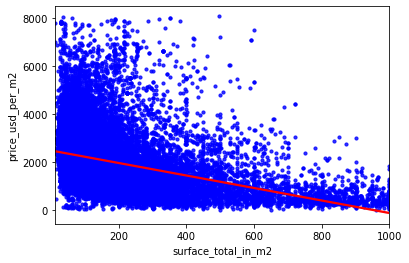

In [7]:
# Superficie total
model1 = lm.fit(X1, y)
model1.coef_
model1.intercept_
test_sklearn_1 = np.array(X1test).reshape(-1,1)
model1.predict(test_sklearn_1)
y1pred = model1.predict(X1test)

print(f'''MAE\t{mean_absolute_error(y1test, y1pred).round(2)}
MSE\t{mean_squared_error(y1test, y1pred).round(2)}
RMSE\t{np.sqrt(mean_squared_error(y1test, y1pred)).round(2)}
R2\t{r2_score(y1test, y1pred).round(2)}''')

sns.regplot(data = data, x = 'surface_total_in_m2', y = 'price_usd_per_m2', ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"})

array([-2.61384529])

2381.775005041239

array([2258.92427649, 2251.08274062, 2021.06435524, ..., 2290.29041995,
       2277.22119351, 2277.22119351])

MAE	748.4
MSE	1057673.79
RMSE	1028.43
R2	0.06


<AxesSubplot:xlabel='surface_covered_in_m2', ylabel='price_usd_per_m2'>

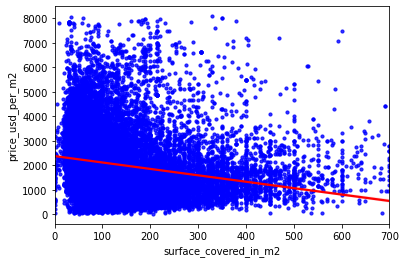

In [8]:
# Superficie cubierta
model2 = lm.fit(X2, y)
model2.coef_
model2.intercept_
test_sklearn_2 = np.array(X2test).reshape(-1,1)
model2.predict(test_sklearn_2)
y2pred = model2.predict(X2test)

print(f'''MAE\t{mean_absolute_error(y2test, y2pred).round(2)}
MSE\t{mean_squared_error(y2test, y2pred).round(2)}
RMSE\t{np.sqrt(mean_squared_error(y2test, y2pred)).round(2)}
R2\t{r2_score(y2test, y2pred).round(2)}''')

sns.regplot(data = data, x = 'surface_covered_in_m2', y = 'price_usd_per_m2', ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"})

array([-96.71856822])

2353.1539851961998

array([2159.71684875, 2159.71684875, 1869.56114408, ..., 2256.43541697,
       2159.71684875, 2159.71684875])

MAE	781.27
MSE	1109205.16
RMSE	1053.19
R2	0.01


<AxesSubplot:xlabel='rooms', ylabel='price_usd_per_m2'>

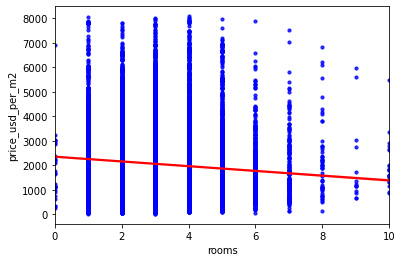

In [9]:
# Habitaciones
model3 = lm.fit(X3, y)
model3.coef_
model3.intercept_
test_sklearn_3 = np.array(X3test).reshape(-1,1)
model3.predict(test_sklearn_3)
y3pred = model3.predict(X3test)

print(f'''MAE\t{mean_absolute_error(y3test, y3pred).round(2)}
MSE\t{mean_squared_error(y3test, y3pred).round(2)}
RMSE\t{np.sqrt(mean_squared_error(y3test, y3pred)).round(2)}
R2\t{r2_score(y3test, y3pred).round(2)}''')

sns.regplot(data = data, x = 'rooms', y = 'price_usd_per_m2', ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"})

### RLS a una feature a la vez **normalizando**

Text(0.5, 0, 'SurfTot standardized')

Text(0, 0.5, 'PUPM standardized')

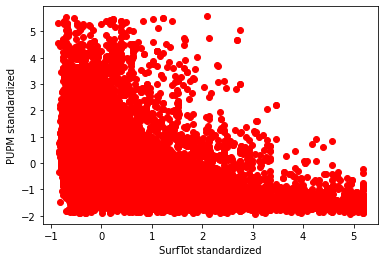

In [54]:
#Normalizo con surface_total_in_m2
xs = preprocessing.scale(data[["surface_total_in_m2"]])
ys = preprocessing.scale(data["price_usd_per_m2"])

plt.scatter(xs, ys, color='r')
plt.xlabel("SurfTot standardized")
plt.ylabel("PUPM standardized")
plt.show()

array([-0.39805165])

3.3293719466975197e-16

array([0.22253768, 0.22011191, 0.0309017 , ..., 0.27590466, 0.26862734,
       0.25407271])

MAE	0.65
MSE	0.82
RMSE	0.91
R2	0.16


<AxesSubplot:>

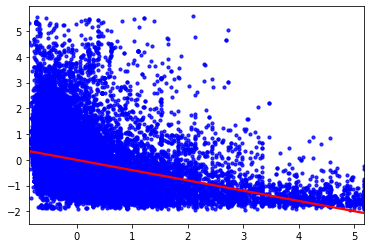

In [55]:
# Aplico modelo sobre variables normalizadas
Xstrain, Xstest, ystrain, ystest = train_test_split(xs, ys, random_state = 1)
lms = LinearRegression() # Fiteamos el modelo sobre los vectores xs e ys.

models = lms.fit(xs, ys)
models.coef_
models.intercept_
test_sklearn_s = np.array(Xstest).reshape(-1,1)
models.predict(test_sklearn_s)
yspred = models.predict(Xstest)

print(f'''MAE\t{mean_absolute_error(ystest, yspred).round(2)}
MSE\t{mean_squared_error(ystest, yspred).round(2)}
RMSE\t{np.sqrt(mean_squared_error(ystest, yspred)).round(2)}
R2\t{r2_score(ystest, yspred).round(2)}''')

sns.regplot(data = data, x = xs, y = ys, ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"})

Comparando los resultados de la regresion lineal simple usando surface_total_in_m2 con y sin normalizacion se tiene:
Sin normalización: 
- MAE	700.94
- MSE	944445.18
- RMSE	971.83
- R2	0.16

Con Normalización
- MAE	0.65
- MSE	0.82
- RMSE	0.91
- R2	0.16

## **Regresión lineal múltiple (RLM)**

### RLM con las 3 features originales juntas **sin normalización**

In [43]:
# Hacemos un modelo utilizando las 3 variables independientes para predecir price_usd_per_m2
X = data[['surface_total_in_m2','surface_covered_in_m2','rooms']]
y = data['price_usd_per_m2']

# Separar entre train y test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

# Importamos, Instanciamos, Fiteamos, etc..

# Instanciamos el modelo.
lm = LinearRegression()

# Fiteamos el modelo sobre los vectores X e y.
model = lm.fit(X, y)
#
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
predictions = lm.predict(X)

# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto=', ' ', model.intercept_)
print ('RM=', ' ', model.coef_)

Intercepto=   2400.626030768864
RM=   [-3.53810322  2.0755816  -0.66875455]


In [44]:
print ('MAE:', metrics.mean_absolute_error(y, predictions))
print ('MSE:', metrics.mean_squared_error(y, predictions))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y, predictions)))
print ('R2:', metrics.r2_score(y, predictions))

MAE: 711.1531114544409
MSE: 954469.8834707387
RMSE: 976.9697454224151
R2: 0.17220192336237305


Text(0.5, 0, 'Predicciones usando todas las variables')

Text(0, 0.5, 'Valores reales ')

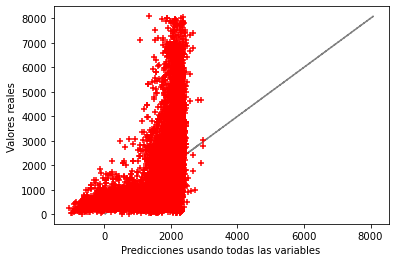

In [46]:
plt.plot(y,y, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando todas las variables")
plt.ylabel("Valores reales ")
plt.show()

### RLM con TODOS los features (dummies incluidos) **sin normalizar**

In [48]:
# Hacemos un modelo utilizando todos los features
X_todo = data[data.columns.difference(["price_usd_per_m2"])]
y_todo = data['price_usd_per_m2']

# Separar entre train y test
X_todo_train, X_todo_test, y_todo_train, y_todo_test = train_test_split(X_todo, y_todo)

# Importamos, Instanciamos, Fiteamos, etc..

# Instanciamos el modelo.
lm_todo = LinearRegression()

# Fiteamos el modelo sobre los vectores X e y.
model_todo = lm_todo.fit(X_todo, y_todo)
#
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
predictions_todo = lm_todo.predict(X_todo)

# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
#print ('Intercepto=', ' ', model.intercept_)
#print ('RM=', ' ', model.coef_)
print ('MAE:', metrics.mean_absolute_error(y_todo, predictions_todo))
print ('MSE:', metrics.mean_squared_error(y_todo, predictions_todo))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_todo, predictions_todo)))
print ('R2:', metrics.r2_score(y_todo, predictions_todo))

MAE: 431.3277062742487
MSE: 392026.3323797727
RMSE: 626.1200622722232
R2: 0.6600011697014139


Text(0.5, 0, 'Predicciones usando todas las variables')

Text(0, 0.5, 'Valores reales ')

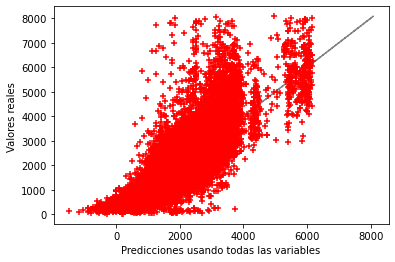

In [49]:
plt.plot(y_todo,y_todo, '-.',c='grey')
plt.scatter(predictions_todo, y_todo, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando todas las variables")
plt.ylabel("Valores reales ")
plt.show()